# Multi linear model

Single shot multi linear model

In [34]:
import time

import pandas as pd
import tensorflow as tf

from window import WindowGenerator
import utils

## Dataset

In [35]:
case_1 = pd.read_csv("../datasets/case_1.csv", index_col='Time')
case_2 = pd.read_csv("../datasets/case_2.csv", index_col='Time')
case_3 = pd.read_csv("../datasets/case_3.csv", index_col='Time')
case_4 = pd.read_csv("../datasets/case_4.csv", index_col='Time')
case_5 = pd.read_csv("../datasets/case_5.csv", index_col='Time')

In [36]:
outlets = [ col for col in case_1.columns.values if col.startswith('outlet') ]
label_columns = outlets[1:]

In [37]:
column_indices = { name: i for i, name in enumerate(case_1.columns) }

## Model creation

In [38]:
IN_WIDTH = 18
OUT_STEPS = 18
MAX_EPOCHS = 20
features_size = len(label_columns)

print(f"Using {IN_WIDTH*5//60}min {IN_WIDTH*5 % 60}s of data to predict {OUT_STEPS*5//60}min {IN_WIDTH*5 % 60}s into de future.")

Using 1min 30s of data to predict 1min 30s into de future.


In [39]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.0005), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.0005), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, kernel_regularizer=tf.keras.regularizers.l2(0.0005), activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Dropout
    # tf.keras.layers.Dropout(rate=0.5),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*features_size,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, features_size])
])

In [40]:
multi_linear_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [41]:
exec_times = {}

In [42]:
results = {}

## Case 2

In [43]:
start_t = time.time()

window, history = utils.train_case(
    case_df=case_2,
    model=multi_linear_model,
    label_cols=label_columns,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_2'] = time.time() - start_t

2022-10-10 16:35:36.555467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-10 16:35:37.120375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [44]:
multi_linear_model.build(input_shape=window.example[0].shape)
multi_linear_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 272)            0         
                                                                 
 dense_4 (Dense)             (None, 1, 10)             2730      
                                                                 
 dropout_3 (Dropout)         (None, 1, 10)             0         
                                                                 
 dense_5 (Dense)             (None, 1, 10)             110       
                                                                 
 dropout_4 (Dropout)         (None, 1, 10)             0         
                                                                 
 dense_6 (Dense)             (None, 1, 10)             110       
                                                                 
 dropout_5 (Dropout)         (None, 1, 10)            

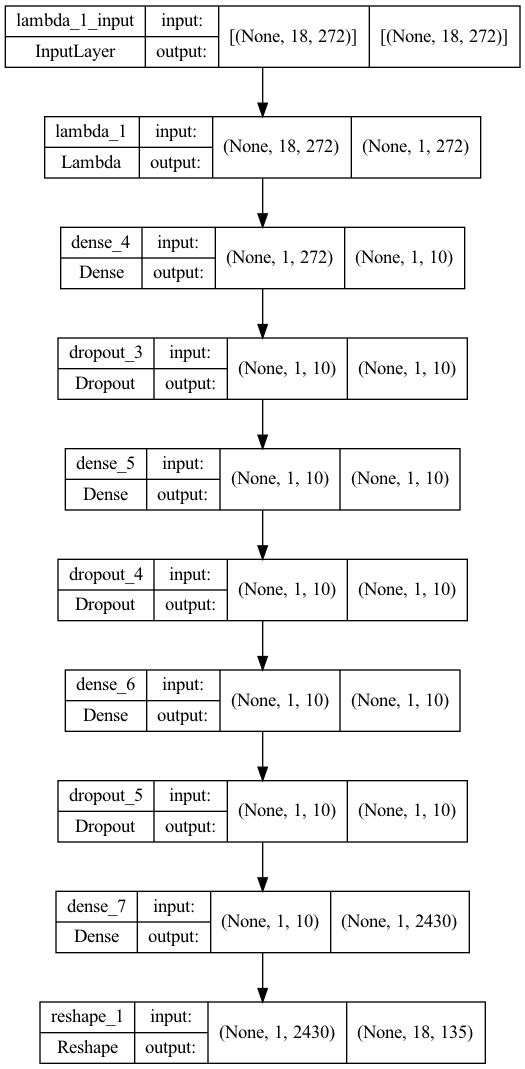

In [45]:
tf.keras.utils.plot_model(multi_linear_model, "../plots/models/multi_lineal.png", show_shapes=True)

label_col_index 134
label_col_index 134
label_col_index 134


2022-10-10 16:35:45.910044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


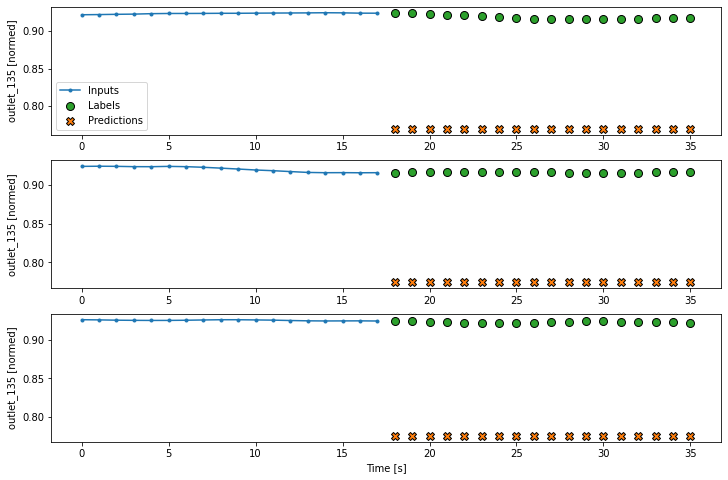

In [46]:
window.plot(multi_linear_model, plot_col="outlet_135")

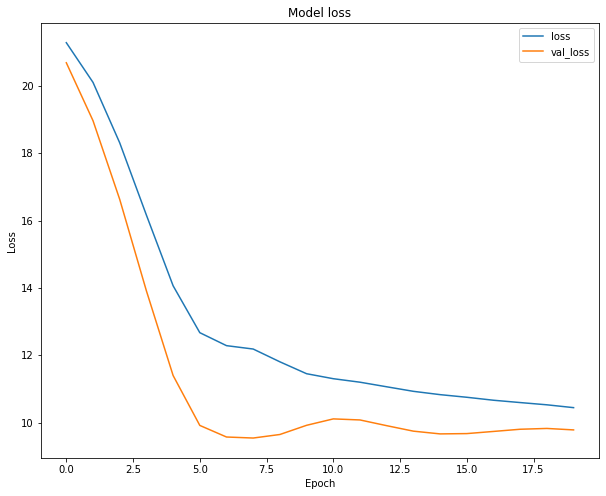

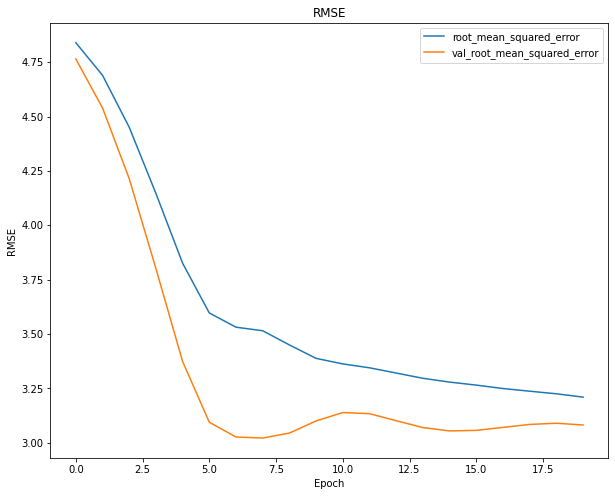

In [47]:
utils.plot_losses(history=history)

In [48]:
results['case_2'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 3

In [49]:
start_t = time.time()

window, history = utils.train_case(
    case_df=case_3,
    model=multi_linear_model,
    label_cols=label_columns,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_3'] = time.time() - start_t

label_col_index 134
label_col_index 134
label_col_index 134


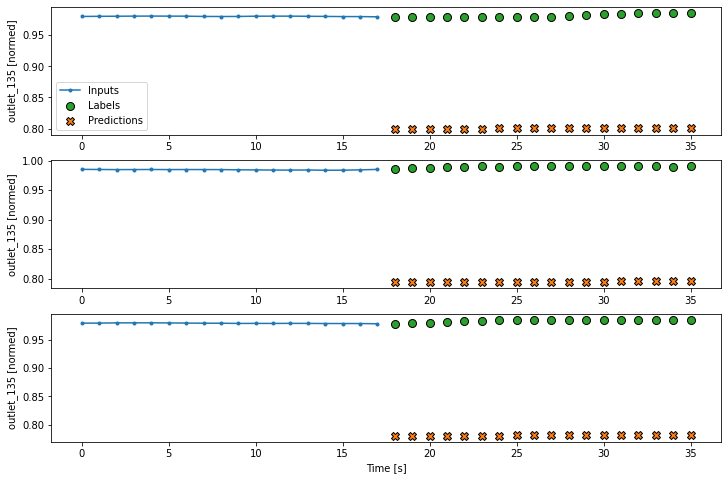

In [50]:
window.plot(multi_linear_model, plot_col="outlet_135")

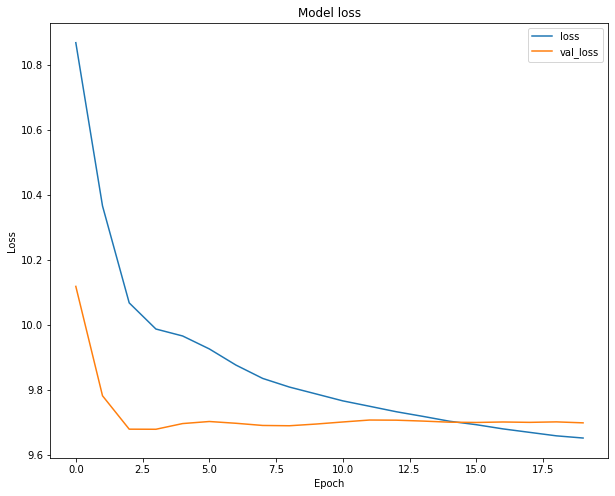

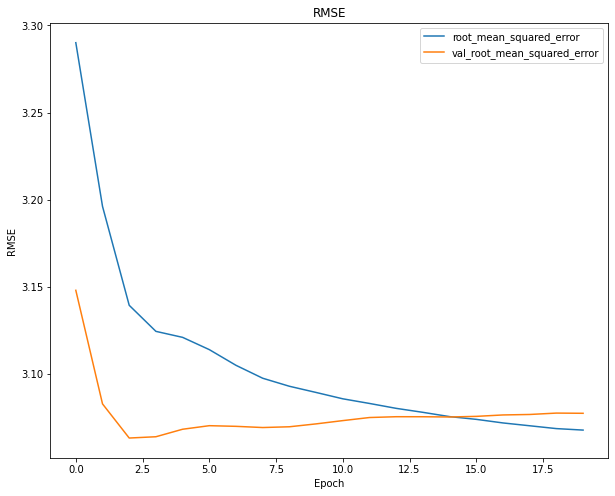

In [51]:
utils.plot_losses(history=history)

In [52]:
results['case_3'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 4

In [53]:
start_t = time.time()

window, history = utils.train_case(
    case_df=case_4,
    model=multi_linear_model,
    label_cols=label_columns,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)
exec_times['case_4'] = time.time() - start_t

label_col_index 134
label_col_index 134
label_col_index 134


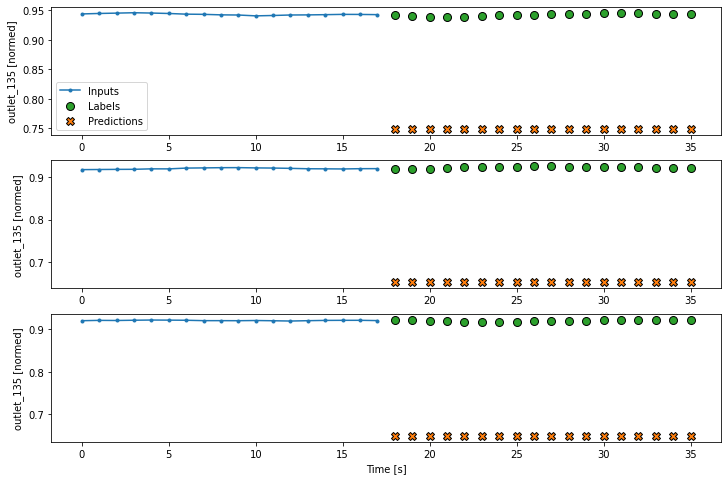

In [54]:
window.plot(multi_linear_model, plot_col="outlet_135")

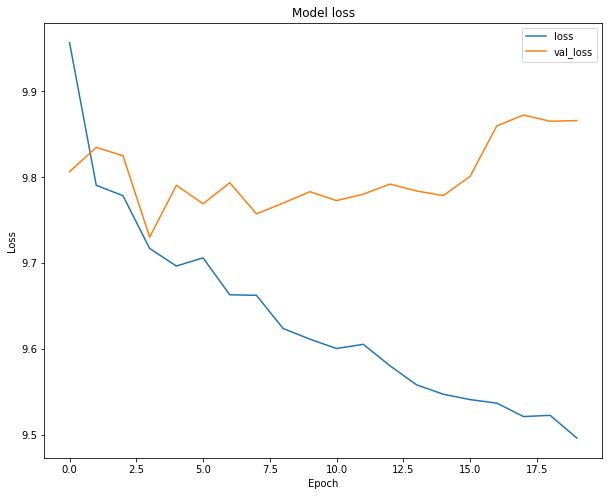

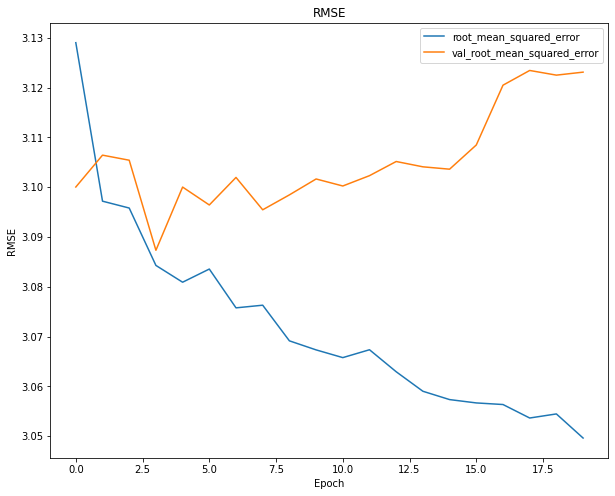

In [55]:
utils.plot_losses(history=history)

In [56]:
results['case_4'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 5

In [57]:
start_t = time.time()

window, history = utils.train_case(
    case_df=case_5,
    model=multi_linear_model,
    label_cols=label_columns,
    in_width=IN_WIDTH,
    out_steps=OUT_STEPS,
    max_epochs=MAX_EPOCHS
)

exec_times['case_5'] = time.time() - start_t

label_col_index 134
label_col_index 134
label_col_index 134


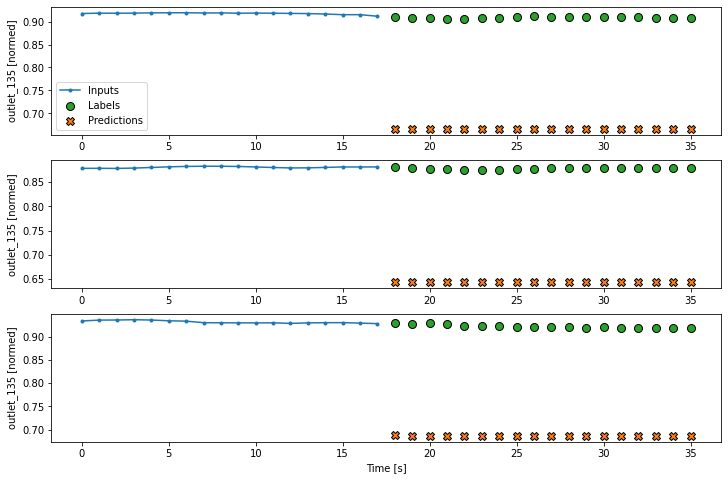

In [58]:
window.plot(multi_linear_model, plot_col="outlet_135")

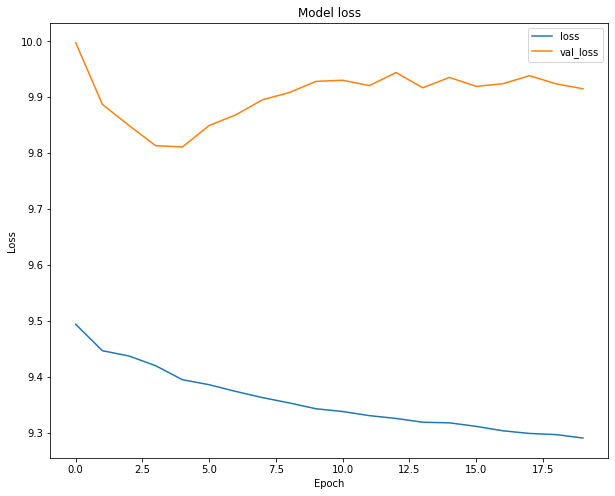

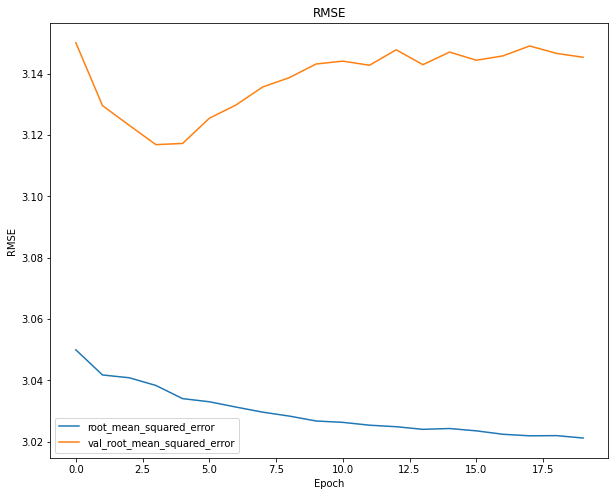

In [59]:
utils.plot_losses(history=history)

In [60]:
results['case_5'] = {
    'loss': history.history['loss'][-1],
    'rmse': history.history['root_mean_squared_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_rmse': history.history['val_root_mean_squared_error'][-1],
}

## Case 1 (Testing)

In [61]:
window = WindowGenerator(
    train_df=case_1,
    input_width=IN_WIDTH,
    label_width=OUT_STEPS,
    shift=OUT_STEPS,
    label_columns=label_columns
)

test_results = multi_linear_model.evaluate(window.train)

5/5 [==============================] - 0s 12ms/step - loss: 0.0588 - root_mean_squared_error: 0.2514


label_col_index 134
label_col_index 134
label_col_index 134


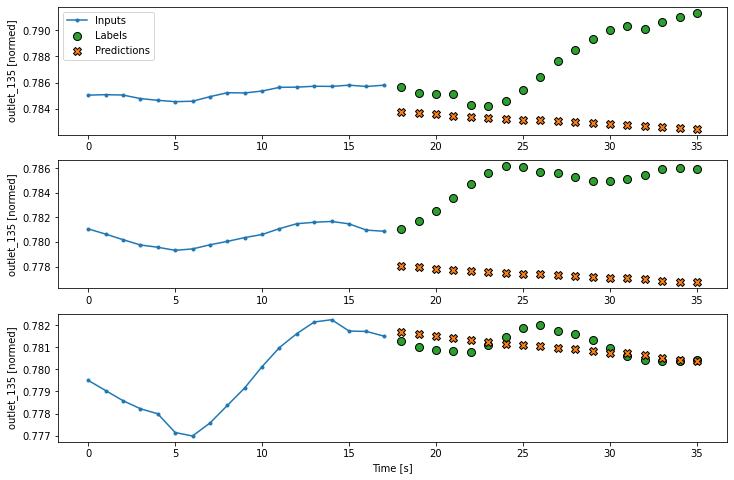

In [62]:
window.plot(multi_linear_model)

## Results

In [63]:
results['test'] = {
    'loss': utils.inverse_transform_loss(test_results[0]),
    'rmse': utils.inverse_transform_rmse(test_results[1])
}

In [64]:
pd.DataFrame(results).transpose().round(2)

,loss,rmse,val_loss,val_rmse
case_2,10.44,3.21,9.78,3.08
case_3,9.65,3.07,9.70,3.08
case_4,9.50,3.05,9.87,3.12
case_5,9.29,3.02,9.92,3.15
test,10.49,3.26,NaN,NaN


In [65]:
exec_times_df = pd.DataFrame().from_dict(exec_times, orient='index', columns=['Time'])
exec_times_df.round(2)

,Time
case_2,9.85
case_3,9.39
case_4,10.25
case_5,12.78


In [66]:
print("Total training time: %.2fs" % exec_times_df['Time'].sum())

Total training time: 42.27s
